# Generate Synthetic Data for LLM Inference   
---
Python notebook to generate data we can then pass into a stronger model (e.g., L4 Maverick, gpt-oss-120b) to give us explanation traces for why a move is a good/bad move.

Use Stockfish to rollout the expected outcome. Sample would be some introductory prompt followed by:

> Playing b5e2 is a reasonable move (Δ +50 cp). The line would likely follow:  
> 1) Your black bishop at b5 captures opponent’s knight at e2  
> 2) Opponent’s white king at e1 captures your bishop at e2  
> 3) You move(s) the black queen from d8 to f6  
> 4) Opponent move(s) the white king from e2 to d1  
> 5) Your black rook at g8 captures opponent’s pawn at g7

Then we ask the model to think through the line and in answer tags produce an explanation that summarizes how the line would play out followed by a verdict.

In [1]:
import os, sys, asyncio
import random, json
import numpy as np
import pandas as pd
from typing import List, Tuple
from IPython.display import SVG, display
from pathlib import Path

import chess
import chess.svg
import chess.engine

if sys.platform == "win32":
    asyncio.set_event_loop_policy(asyncio.WindowsProactorEventLoopPolicy())

from utils.board import convert_board

In [2]:
class SingleMoveTrace:
    """One-move trace. Modes: 'best', 'worst', 'reasonable'."""
    STOCKFISH_PATH = "../programmatic_explanations/stockfish/stockfish-windows-x86-64-avx2.exe"

    SWING_CP = 200
    MIN_REASONABLE = -50
    GOOD_CP = 50
    MATE_CP = 10_000

    PIECE = {
        chess.PAWN: "pawn", chess.KNIGHT: "knight", chess.BISHOP: "bishop",
        chess.ROOK: "rook", chess.QUEEN: "queen", chess.KING: "king",
    }

    def __init__(self, mode: str = "worst", *, temp: float = 2.5, max_plies: int = 4,
                 depth: int = 10, multipv: int = 40, opponent_depth_penalty: int = 5) -> None:
        if mode not in {"best", "worst", "reasonable"}:
            raise ValueError("mode must be 'best', 'worst', or 'reasonable'")
        self.mode, self.temp, self.max_plies = mode, temp, max_plies
        self.depth, self.multipv, self.opp_pen = depth, multipv, max(0, opponent_depth_penalty)
        self.engine = chess.engine.SimpleEngine.popen_uci(self.STOCKFISH_PATH)

    def close(self) -> None:
        self.engine.quit()

    # Unified API: returns (narr_lines, move, final_fen)
    def analyze(self, fen: str):
        board = chess.Board(fen)
        root_side = board.turn
        infos = self._analyse(board, multipv=self.multipv)
        infos.sort(key=lambda inf: self._cp(inf["score"].pov(root_side)))

        if self.mode == "best":
            return self._best_line(board, infos, root_side)
        if self.mode == "reasonable":
            return self._reasonable_line(board, root_side)
        return self._worst_line(board, infos, root_side)

    # ----------- modes -----------
    def _best_line(self, board, infos, root_side):
        info = infos[-1]; mv = info["pv"][0]
        start_cp = self._eval(board, root_side)
        immediate_cp = self._eval_after(board, mv, root_side)  # post-move eval
        delta_first = immediate_cp - start_cp

        moves, final_cp, final_fen = self._rollout(board, mv, root_side, opponent_depth_penalty=self.opp_pen)
        if final_cp - start_cp < self.GOOD_CP:
            raise ValueError("Best move gain below GOOD_CP (final-start).")

        intro = f"Playing {self._mvs(mv)} improves {delta_first:+.0f} cp immediately; line could go:"
        narr = self._dictate(board, moves, root_side, intro=intro)
        return narr, mv, final_fen

    def _worst_line(self, board, infos, root_side):
        start_cp = self._eval(board, root_side)
        cps = np.array([self._cp(i["score"].pov(root_side)) for i in infos])
        probs = self._safe_softmax(-(cps - cps.max()) / (100 * max(self.temp, 1e-6)))

        for idx in np.random.choice(len(infos), len(infos), replace=False, p=probs):
            mv = infos[idx]["pv"][0]
            # immediate delta must reflect state-to-state drop
            immediate_cp = self._eval_after(board, mv, root_side)
            delta_first = immediate_cp - start_cp

            moves, final_cp, final_fen = self._rollout(board, mv, root_side, opponent_depth_penalty=0)
            if abs(final_cp - start_cp) >= self.SWING_CP:
                intro = f"Playing {self._mvs(mv)} blunders {delta_first:+.0f} cp immediately; line likely goes:"
                narr = self._dictate(board, moves, root_side, intro=intro)
                return narr, mv, final_fen
        raise ValueError("No move within MULTIPV produced a ≥ SWING_CP swing.")

    def _reasonable_line(self, board, root_side):
        # Sample ONLY the first move at depth=12 among non-blunders; rest optimal (opp handicap=2) at base_depth=5.
        infos = self._analyse(board, multipv=self.multipv, depth=12)
        cps = np.array([self._cp(i["score"].pov(root_side)) for i in infos])
        keep = np.where(cps >= self.MIN_REASONABLE)[0]
        if keep.size == 0:
            raise ValueError("No reasonable moves (>= MIN_REASONABLE).")

        logits = (cps[keep] - cps[keep].max()) / (100 * max(self.temp, 1e-6))
        probs = self._safe_softmax(logits)
        mv = infos[int(np.random.choice(keep, p=probs))]["pv"][0]

        start_cp = self._eval(board, root_side)
        immediate_cp = self._eval_after(board, mv, root_side)
        delta_first = immediate_cp - start_cp

        # Determine position assessment based on delta_first
        if delta_first < -50:
            assessment = "deteriorates your position"
        elif delta_first <= 50:
            assessment = "is a reasonable move"
        elif delta_first <= 150:
            assessment = "improves your position"
        else:
            assessment = "is a very smart move"

        moves, final_cp, final_fen = self._rollout(
            board, mv, root_side, opponent_depth_penalty=4, base_depth=5
        )
        intro = f"Playing {self._mvs(mv)} {assessment} (Δ {delta_first:+.0f} cp). The line would likely follow:"
        narr = self._dictate(board, moves, root_side, intro=intro)
        return narr, mv, final_fen

    # ----------- engine helpers -----------
    def _analyse(self, board, *, multipv: int = 1, depth: int | None = None):
        d = self.depth if depth is None else max(1, depth)
        return self.engine.analyse(board, chess.engine.Limit(depth=d), multipv=multipv)

    def _eval(self, board, pov_color) -> int:
        """Eval current board from pov_color."""
        return self._cp(self._analyse(board)[0]["score"].pov(pov_color))

    def _eval_after(self, board, move, pov_color, depth: int | None = None) -> int:
        """Eval board after applying move, from pov_color (push/pop safe)."""
        board.push(move)
        cp = self._cp(self._analyse(board, depth=depth)[0]["score"].pov(pov_color))
        board.pop()
        return cp

    def _cp(self, score: chess.engine.Score) -> int:
        if score.is_mate():
            return self.MATE_CP if score.mate() > 0 else -self.MATE_CP
        v = score.score(mate_score=self.MATE_CP)
        return 0 if v is None else v

    @staticmethod
    def _safe_softmax(x: np.ndarray) -> np.ndarray:
        x = x - np.max(x)
        ex = np.exp(x)
        s = ex.sum()
        return np.full_like(x, 1 / len(x), dtype=float) if s == 0 or np.isnan(s) else ex / s

    # ----------- rollout & narration -----------
    def _rollout(self, board, first_move, root_side, *, opponent_depth_penalty=0, base_depth: int | None = None):
        base = self.depth if base_depth is None else max(1, base_depth)
        moves = [first_move]; board.push(first_move)

        while len(moves) < self.max_plies:
            side = board.turn
            look = max(1, base - opponent_depth_penalty) if side != root_side and opponent_depth_penalty > 0 else base
            info = self._analyse(board, depth=look)[0]
            pv = info.get("pv")
            if not pv: break
            mv = pv[0]; moves.append(mv); board.push(mv)
            if len(moves) >= self.max_plies: break

        final_fen = board.fen()
        final_cp = self._eval(board, root_side)  # full depth (self.depth)
        while board.move_stack: board.pop()
        return moves, final_cp, final_fen

    def _dictate(self, start_board, moves, root_side, *, intro: str):
        lines, b = [intro], start_board.copy()
        for mv in moves:
            you = b.turn == root_side
            mover = "black" if b.turn == chess.BLACK else "white"
            piece = self.PIECE[b.piece_type_at(mv.from_square)]
            frm, to = chess.square_name(mv.from_square), chess.square_name(mv.to_square)
            if b.is_capture(mv):
                victim = b.piece_at(mv.to_square) if not b.is_en_passant(mv) else b.piece_at(chess.square(chess.square_file(mv.to_square), chess.square_rank(mv.from_square)))
                vp = self.PIECE[victim.piece_type]
                lines.append(f"{'Your' if you else 'Opponent’s'} {mover} {piece} at {frm} captures {'opponent’s' if you else 'your'} {vp} at {to}")
            else:
                lines.append(f"{'You' if you else 'Opponent'} move(s) the {mover} {piece} from {frm} to {to}")
            b.push(mv)
        return [lines[0]] + [f"{i}) {s}" for i, s in enumerate(lines[1:], 1)]

    @staticmethod
    def _mvs(mv: chess.Move) -> str:
        return chess.square_name(mv.from_square) + chess.square_name(mv.to_square)


### Visualize and test our samples

In [3]:
df = pd.read_csv('chess_data/deepmind_behaviorcloning_100k.csv')
bad_sampler = SingleMoveTrace(
    mode = 'worst',
    temp = 5.0,
    max_plies = 4,
    depth = 10,
    multipv = 40
)
best_sampler = SingleMoveTrace(
    mode = 'best', 
    temp = 0.2,
    max_plies = 7,
    depth = 12,
    multipv = 1
)
reasonable_sampler = SingleMoveTrace(
    mode = 'reasonable', 
    temp = 0.5,
    max_plies = 5,
    depth = 12,
    multipv = 5
)

Samples Looped: 3
FEN: 4r3/1pp4k/p1p4p/4RP2/1P1N2p1/6Pb/PP6/3R2K1 b - - 0 32


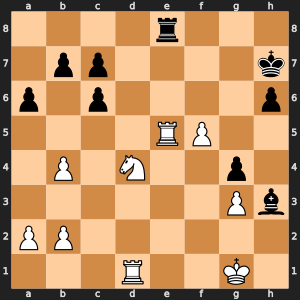

Move: e8e5
Playing e8e5 is a reasonable move (Δ -16 cp). The line would likely follow:
1) Your black rook at e8 captures opponent’s rook at e5
2) Opponent move(s) the white knight from d4 to e6
3) Your black rook at e5 captures opponent’s pawn at f5
4) Opponent move(s) the white rook from d1 to d7
5) You move(s) the black king from h7 to g8


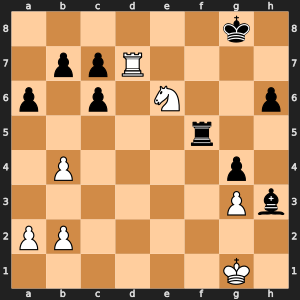

In [4]:
def quick_sample(mode='worst', max_samples=40):
    sampler = {'worst': bad_sampler, 'best': best_sampler, 'reasonable': reasonable_sampler}[mode]
    shuffled_df = df.sample(frac=1).reset_index(drop=True)
    samples_looped = 0
    
    for i in range(min(max_samples, len(shuffled_df))):
        samples_looped += 1
        try:
            fen = shuffled_df.iloc[i]['FEN']
            trace, move, final_fen = sampler.analyze(fen)
            print(f"Samples Looped: {samples_looped}")
            print(f"FEN: {fen}")
            display(SVG(chess.svg.board(board=chess.Board(fen), size=300)))
            print(f"Move: {move}")
            for line in trace:
                print(line)
            if final_fen:
                display(SVG(chess.svg.board(board=chess.Board(final_fen), size=300)))
            return
        except:
            continue
    print("No valid samples found")

quick_sample('reasonable')

In [5]:
def generate_trace_dataset(
    sampler,                      # pre-configured SingleMoveTrace instance
    df,                           # pandas DataFrame with a “FEN” column
    convert_board,                # fn(fen, notation) -> str
    *,
    num_samples: int = 10,
    board_notation: str = "uniform_visual",
    out_dir: str = "processed_data",
) -> list[dict]:
    """
    Build a JSONL dataset of “good-move” *or* “blunder” explanations, depending
    on `sampler.mode` ('best' or 'worst').

    Returns the in-memory list as well.
    """
    # Shuffle once
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    label_map = {
        "best": "good move",
        "worst": "blunder",
        "reasonable": "reasonable move",
    }

    label = label_map[sampler.mode]

    sys_prompt  = f"{label.replace(' ', '')}_syntheticgenerator_sysprompt.txt"
    out_path    = Path(out_dir)
    out_path.mkdir(exist_ok=True)
    outfile     = out_path / f"{label.replace(' ', '')}_explanations_{num_samples}.jsonl"

    dataset, ok, errs = [], 0, 0
    print(f"Generating {num_samples} {label} samples…")

    idx = 0
    total_rows = len(df)

    while ok < num_samples and idx < total_rows:
        try:
            fen = df.loc[idx, "FEN"]
            idx += 1

            trace, mv, final_fen = sampler.analyze(fen)
            final_board = f"The final board after this line plays out is:\n{convert_board(final_fen, board_notation)}\n\n" if final_fen else ""

            trace_text = '\n'.join(trace)
            prompt = (
                f"Below is a board in a game you're currently playing.\n\n"
                f"{convert_board(fen, board_notation)}\n\n"
                f"{trace_text}\n\n"
                f"{final_board}"
                "Remember — wrap your final explanation in <answer> tags and reason through this task before answering."
            )

            dataset.append(
                {
                    "chat": [
                        ["system", sys_prompt],
                        ["user", prompt],
                        ["assistant", ""],
                    ],
                    "info": {
                        "board": fen,
                        "move": chess.square_name(mv.from_square)
                                + chess.square_name(mv.to_square),
                    },
                }
            )
            ok += 1
            if ok % 1_000 == 0:
                print(f"{ok}/{num_samples}")

        except ValueError:  # sampler found no qualifying move
            errs += 1
        except Exception as e:
            print("Unexpected:", e)

    with open(outfile, "w") as fh:
        for s in dataset:
            fh.write(json.dumps(s) + "\n")

    print(f"Saved to {outfile}  |  success {ok}  |  ValueErrors {errs}")
    return dataset

In [6]:
# Blunder dataset
# blunder_ds = generate_trace_dataset(bad_sampler, df, convert_board, num_samples=10000)

# Good move dataset
# good_ds = generate_trace_dataset(best_sampler, df, convert_board, num_samples=5000)

# Reasonable move dataset
reasonable_ds = generate_trace_dataset(reasonable_sampler, df, convert_board, num_samples=5)

Generating 5 reasonable move samples…
Saved to processed_data\reasonablemove_explanations_5.jsonl  |  success 5  |  ValueErrors 1
